# Experiments

We ran experiments on MNIST with 10 different weight initializations using an overparameterization of $1000$ hidden units. The results are an average over 5 runs for each configuration.

The following command generates the bash commands that will run the experiments. If you do not have a High Performance Computing setup you can remove `--remote` to run them locally in sequence instead (be aware that this might take prohibitively long, however, since there are 50 experiment in total).

**Table of content**:
    
1. *Setup*.
    Loads dependencies and defines helper to construct pandas dataframe.
2. *Train Teacher Network*.
    Script for training the teacher network.
3. *Train Student Networks*.
    Generates the scripts for running the student networks on a Slurm cluster.
4. *View Student Networks*.
    Downloads the output from the cluster, aggregates the experiments in a pandas dataframe, and creates the Figure 1 in the paper.

## Setup

In [1]:
import os
import re
import math
import glob
import warnings
import subprocess
import pickle

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from src.latexify import *

def construct_data_frame(exp_dirs):
    """Construct a pandas dataframe for a list of experiments 
    using their associated files.
    """
    def get_last_entry(filename):
        line = subprocess.check_output(['tail', '-1', filename])
        try:
            entry = line.split()[1:]
            return entry
        except ValueError:
            warnings.warn(f"Experiment {filename} cannot be processed.")
            return None

    entries = []

    for i, exp_dir in enumerate(exp_dirs):
        args_fp = open(os.path.join(exp_dir, 'arguments.p'), 'rb')
        args = pickle.load(args_fp)
        w1 = args.w1
        w2 = args.w2
        args_fp.close()

        print(exp_dir)
        training_loss_filename = glob.glob(os.path.join(exp_dir, 'epoch-loss-*.txt'))[0]
        test_loss_filename = glob.glob(os.path.join(exp_dir, 'test-loss-*.txt'))[0]

        try:
            train_loss, train_acc = get_last_entry(training_loss_filename)
            test_loss, test_acc = get_last_entry(test_loss_filename)

            train_loss = float(train_loss)
            test_loss = float(test_loss)
            train_acc = float(train_acc)
            test_acc = float(test_acc)
        except:
            train_loss = np.inf
            test_loss = np.inf
            train_acc = np.inf
            test_acc = np.inf

        entry = {
            'w1': w1,
            'w2': w2,
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'current_epoch': sum(1 for line in open(training_loss_filename)),
            'args': args,
        }
        entries.append(entry)

    df = pd.DataFrame(entries)
    return df

### Setup He weights

In [2]:
# Generate the He initialization
input_dim = 784
output_dim = 10
network_width = 1000
he_w1 = np.sqrt(2 / (input_dim))
he_w2 = np.sqrt(2 / (network_width))
print(he_w1, he_w2)

0.050507627227610534 0.044721359549995794


## Train Teacher network

_Note: The resulting model is already stored in `teacher_mode.pth` so there is no need to recreate this._

First we generate the teacher network.
The teacher is trained with cross entropy. Here we generate the script to train it on the server and subsequently move it to the designated teacher network path `./teacher_model.pth`.

In [21]:
epoch = 300
batch_size = 128
lr = 0.01

name = 'mnist-he-teacher'
uuid = f"{name}-{he_w1}-{he_w2}"

print(f"python runner.py --exp-name {uuid} --d1 1000 --dataset MNIST --lr {lr} --w1 {he_w1} --w2 {he_w2} --epochs {epoch} --batch-size {batch_size} --remote")


python runner.py --exp-name mnist-he-teacher-0.050507627227610534-0.044721359549995794 --d1 1000 --dataset MNIST --lr 0.01 --w1 0.050507627227610534 --w2 0.044721359549995794 --epochs 300 --batch-size 128 --remote


_The above output can be run from the shell. Remove `--remote` to run the script locally_.

In [22]:
# Move the teacher model to the fixed reserved location
!make pull
subprocess.check_output(["cp", f"output/{uuid}/model.pth", "teacher_model.pth"])
!ls | grep 'teacher_model.pth'

if [ "$SERVER_NAME" ]; then rsync -av @:~/overparameterization/output ./; fi
teacher_model.pth


## Train Student Networks

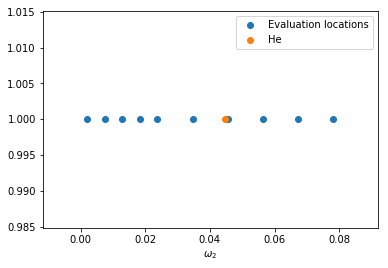

In [16]:
# Decides for what w1/w2 initialization we should conduct experiments
W1W2 = he_w1 * he_w2

line = np.linspace(0.002, 0.1, 10)
locations = np.array([
    line[0], 
    line[0] + (line[1] - line[0]) / 2,
    line[1],
    line[1] + (line[2] - line[1]) / 2,
    line[2],
    line[3],
    line[4],
    line[5],
    line[6],
    line[7],
    ])

plt.scatter(locations, np.repeat(1,10), label="Evaluation locations")
plt.scatter(he_w2, 1, label="He")
plt.legend()
plt.xlabel('$\omega_2$')
None

In [17]:
# Generate the script for running the 50 experiments on the SLURM server
epoch = 300
batch_size = 128
lr = 0.01
W2 = locations
activation = 'gelu'
name = f'mnist-he-student-mse-{activation}'

for i in range(0, 5):
    for w2 in W2:
        w1 = W1W2 / w2
        print(f"python runner.py --exp-name {name}-i{i}-{w1}-{w2} --d1 1000 --dataset MNIST --lr {lr} --w1 {w1} --w2 {w2} --epochs {epoch} --batch-size {batch_size} --activation {activation} --remote --teacher")

# Missing (and onwards): mnist-he-student-mse-gelu-i1-0.03354608550390784-0.06733333333333333

python runner.py --exp-name mnist-he-student-mse-gelu-i0-1.129384878631564-0.002 --d1 1000 --dataset MNIST --lr 0.01 --w1 1.129384878631564 --w2 0.002 --epochs 300 --batch-size 128 --activation gelu --remote --teacher
python runner.py --exp-name mnist-he-student-mse-gelu-i0-0.3034168330651963-0.0074444444444444445 --d1 1000 --dataset MNIST --lr 0.01 --w1 0.3034168330651963 --w2 0.0074444444444444445 --epochs 300 --batch-size 128 --activation gelu --remote --teacher
python runner.py --exp-name mnist-he-student-mse-gelu-i0-0.17524937771869095-0.012888888888888889 --d1 1000 --dataset MNIST --lr 0.01 --w1 0.17524937771869095 --w2 0.012888888888888889 --epochs 300 --batch-size 128 --activation gelu --remote --teacher
python runner.py --exp-name mnist-he-student-mse-gelu-i0-0.12320562312344334-0.018333333333333333 --d1 1000 --dataset MNIST --lr 0.01 --w1 0.12320562312344334 --w2 0.018333333333333333 --epochs 300 --batch-size 128 --activation gelu --remote --teacher
python runner.py --exp-nam

_The above output can be run from the shell. Remove `--remote` to run the scripts locally_.

## View Student Networks

In [12]:
# Pull the results from the server
!make pull

if [ "$SERVER_NAME" ]; then rsync -av @:~/overparameterization/output ./; fi


In [3]:
# Show all experiments
exp_dirs = glob.glob('output/mnist-he-student-mse-gelu-i*')
df = construct_data_frame(exp_dirs)
df = df[df['train_loss'] != np.inf]
df

output/mnist-he-student-mse-gelu-i4-1.129384878631564-0.002
output/mnist-he-student-mse-gelu-i4-0.06515681992105177-0.034666666666666665
output/mnist-he-student-mse-gelu-i4-0.17524937771869095-0.012888888888888889
output/mnist-he-student-mse-gelu-i1-0.04001757443970108-0.05644444444444445
output/mnist-he-student-mse-gelu-i0-0.04001757443970108-0.05644444444444445
output/mnist-he-student-mse-gelu-i0-0.17524937771869095-0.012888888888888889
output/mnist-he-student-mse-gelu-i4-0.04958275076919061-0.04555555555555556
output/mnist-he-student-mse-gelu-i0-0.06515681992105177-0.034666666666666665
output/mnist-he-student-mse-gelu-i0-0.3034168330651963-0.0074444444444444445
output/mnist-he-student-mse-gelu-i0-1.129384878631564-0.002
output/mnist-he-student-mse-gelu-i2-0.04001757443970108-0.05644444444444445
output/mnist-he-student-mse-gelu-i0-0.12320562312344334-0.018333333333333333
output/mnist-he-student-mse-gelu-i4-0.03354608550390784-0.06733333333333333
output/mnist-he-student-mse-gelu-i4-0.

,w1,w2,train_loss,test_loss,train_acc,test_acc,current_epoch,args
0,1.129385,0.002000,4.117531e-07,1.065383,1.000000,0.9639,188,"Namespace(activation='gelu', batch_size=128, c..."
1,0.065157,0.034667,2.228420e-03,0.032281,1.000000,0.9871,278,"Namespace(activation='gelu', batch_size=128, c..."
2,0.175249,0.012889,1.554279e-03,0.068974,1.000000,0.9790,301,"Namespace(activation='gelu', batch_size=128, c..."
3,0.040018,0.056444,2.113709e-03,0.025974,1.000000,0.9900,301,"Namespace(activation='gelu', batch_size=128, c..."
4,0.040018,0.056444,2.114227e-03,0.026822,1.000000,0.9896,301,"Namespace(activation='gelu', batch_size=128, c..."
5,0.175249,0.012889,1.533242e-03,0.066892,1.000000,0.9795,301,"Namespace(activation='gelu', batch_size=128, c..."
6,0.049583,0.045556,2.103177e-03,0.030573,1.000000,0.9880,301,"Namespace(activation='gelu', batch_size=128, c..."
7,0.065157,0.034667,1.995467e-03,0.033782,1.000000,0.9874,301,"Namespace(activation='gelu', batch_size=128, c..."
8,0.303417,0.007444,1.203454e-03,0.115859,1.000000,0.9707,301,"Namespace(activation='gelu', batch_size=128, c..."
9,1.129385,0.002000,2.832237e-07,1.139211,1.000000,0.9647,301,"Namespace(activation='gelu', batch_size=128, c..."


In [4]:
# Show the aggregrated mean and std for both test and train
he_w2 = 0.044721359549995794
agg_df = df.groupby(np.round(df['w2'], 5)).agg({'test_acc': ['mean', 'std', 'count'], 'train_acc': ['mean', 'std', 'count']})
agg_df = agg_df.sort_values('w2', ascending=False)
agg_df = agg_df[agg_df.index <= 0.08]
agg_df = agg_df[~np.isclose(agg_df.index, he_w2, rtol=1e-04, atol=1e-08)]
agg_df.sort_index()

test_acc                 train_acc                
            mean       std count      mean       std count
w2                                                        
0.00200  0.96454  0.001293     5  1.000000  0.000000     5
0.00744  0.97066  0.002458     5  1.000000  0.000000     5
0.01289  0.97882  0.000785     5  0.999960  0.000089     5
0.01833  0.98216  0.000862     5  0.999913  0.000194     5
0.02378  0.98510  0.000967     5  0.999873  0.000283     5
0.03467  0.98758  0.000444     5  0.999833  0.000373     5
0.04556  0.98906  0.000677     5  1.000000  0.000000     5
0.05644  0.98982  0.000585     5  1.000000  0.000000     5
0.06733  0.98962  0.000968     5  1.000000  0.000000     5
0.07822  0.99020  0.000316     5  1.000000  0.000000     5

/Users/tmpethick/anaconda3/envs/ssd/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


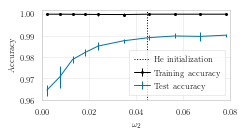

In [5]:
latexify(fig_width=3.5, fig_height=2)
#latexify(fig_width=7.2)

fig, ax = plt.subplots()
agg_df.train_acc['mean'].plot(yerr=2*agg_df.train_acc['std'], label="Training accuracy", logx=False, ax=ax, color='black', marker='.')
agg_df.test_acc['mean'].plot(yerr=2*agg_df.test_acc['std'], label="Test accuracy", logx=False, ax=ax, color='C0', marker='')

plt.axvline(he_w2, color='black', label="He initialization", zorder=3, linestyle=':')

ax.set_xlabel("$\omega_2$")
ax.set_ylabel("Accuracy")
ax.legend()
ax.set_xlim(0.000, 0.08)
ax.set_ylim(0.96, 1.002)
plt.tight_layout()
savefig(fig, 'mnist-he-generalization-error-mse-gelu.pdf', transparent=True)